## UKBB+HCP GLM

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-12-04 20:45:10.683282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 20:45:12.232559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 20:45:14.426851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

# sim imports
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 44.1%
RAM Usage: 17.6%
Available RAM: 310.8G
Total RAM: 377.1G
52.4G


In [6]:
GPUtil.getAvailable()

[]

## Load in structural connectomes

In [7]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


In [8]:
# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC')
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']

## Load in functional connectomes

In [9]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


MRID    Age  IsF     Race
0  1000038_2_0  64.64  1.0  British
1  1000108_2_0  68.39  0.0  British
2  1000149_2_0  76.67  0.0    Irish
3  1000201_2_0  67.24  1.0  British
4  1000213_2_0  67.73  1.0  British

In [17]:
UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[:400, :400]
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


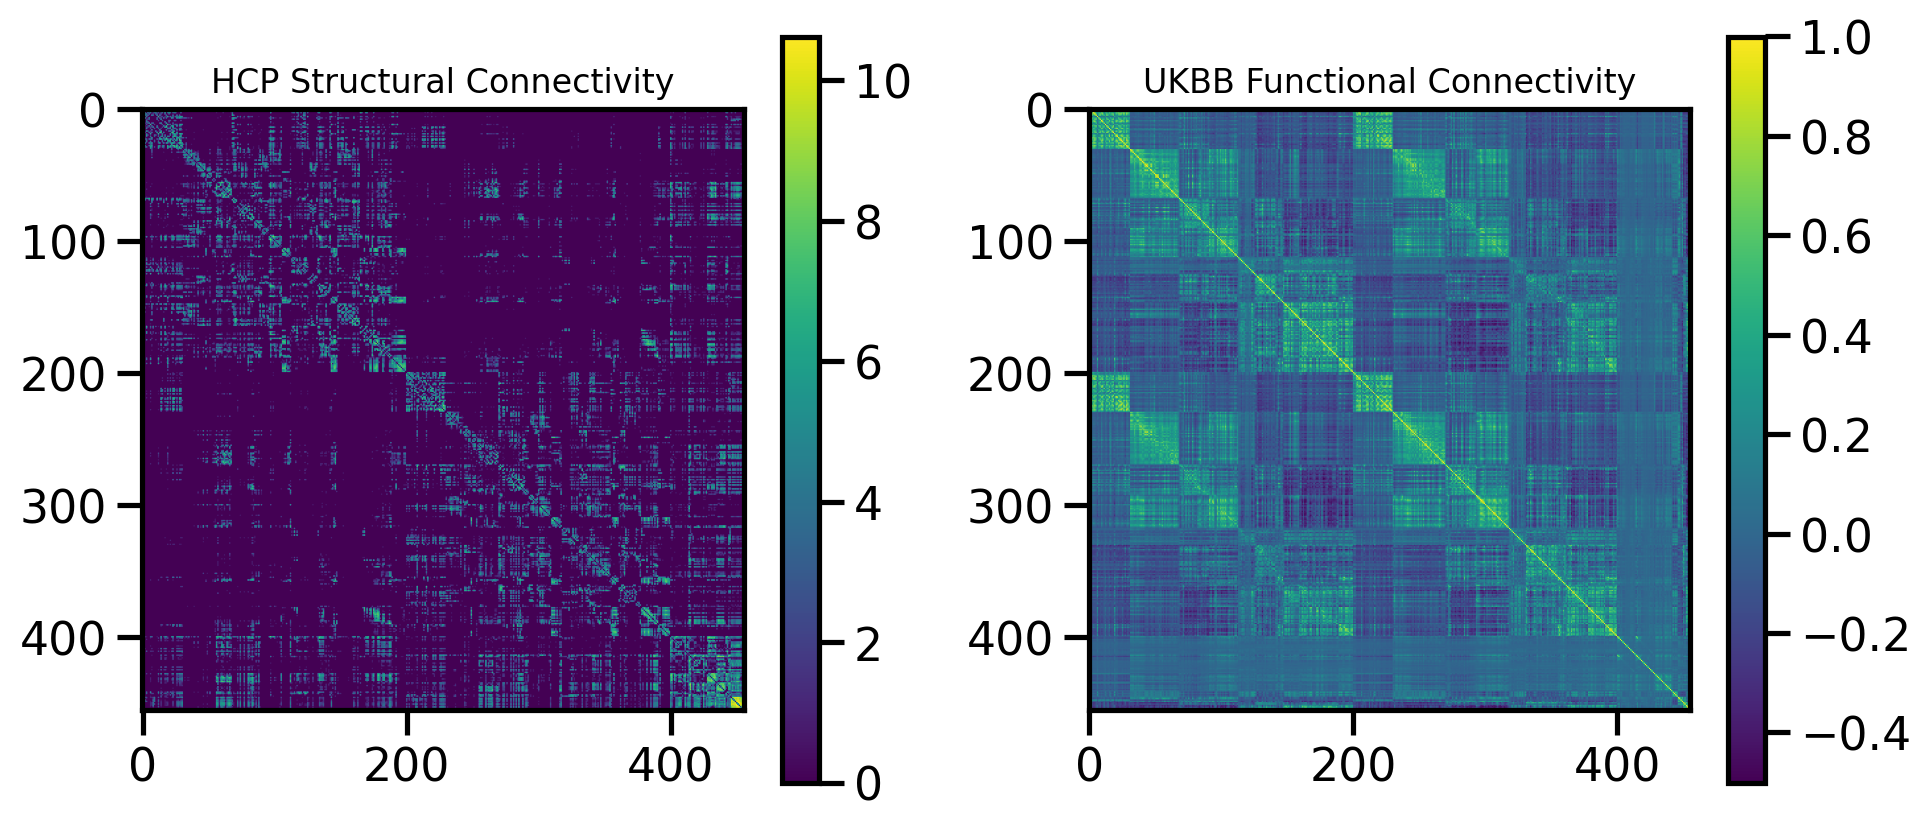

HCP Structure - UKBB Function Correlation: 0.180


In [18]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).flatten(),
                              np.array(UKBB_S456_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


### S456 transcriptome and connectomes

In [19]:
# HCP1200 + UKBB (456)
AHBA_UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/AHBA_population_MH/'
AHBA_S456_transcriptome = pd.read_csv(os.path.join(AHBA_UKBB_path, 'AHBA_schaefer456_mean.csv'))
AHBA_S456_transcriptome


label      A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT  \
0        1  0.561660  0.734501  0.324933  0.535864  0.489417  0.379832   
1        2  0.663557  0.685498  0.441050  0.385992  0.346175  0.443920   
2        3  0.436262  0.643591  0.429456  0.440705  0.431365  0.281185   
3        4  0.425277  0.605727  0.423479  0.535326  0.491737  0.511346   
4        5  0.450135  0.549051  0.424298  0.482207  0.570472  0.454508   
..     ...       ...       ...       ...       ...       ...       ...   
451    452  0.341028  0.094848  0.765552  0.575811  0.704052  0.562898   
452    453  0.463658  0.186620  0.779770  0.576450  0.619368  0.611139   
453    454  0.330321  0.182710  0.778768  0.511883  0.645229  0.616889   
454    455       NaN       NaN       NaN       NaN       NaN       NaN   
455    456  0.529461  0.171250  0.734482  0.632406  0.728757  0.477470   

         AAAS      AACS   AADACL3  ...      ZW10    ZWILCH     ZWINT  \
0    0.326284  0.753036  0.515869  ...  0.418326  0.718180  0.609211   
1    0.412164  0.797134  0.389222  ...  0.426496  0.686967  0.631722   
2    0.540874  0.736296  0.423710  ...  0.499867  0.573895  0.473315   
3    0.550680  0.797199  0.506673  ...  0.598042  0.524854  0.529094   
4    0.502276  0.705437  0.528914  ...  0.437076  0.542980  0.342298   
..        ...       ...       ...  ...       ...       ...       ...   
451  0.461932  0.194017  0.741957  ...  0.369983  0.315040  0.265321   
452  0.491830  0.198539  0.715724  ...  0.485183  0.264759  0.221240   
453  0.622842  0.200763  0.715024  ...  0.430804  0.199255  0.221837   
454       NaN       NaN       NaN  ...       NaN       NaN       NaN   
455  0.378586  0.111168  0.764168  ...  0.288623  0.199032  0.178801   

         ZXDA      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1      ZZZ3  
0    0.559397  0.536330  0.543115  0.781127  0.494951  0.548834  0.421155  
1    0.469606  0.454834  0.465253  0.669610  0.508163  0.423381  0.551138  
2    0.455233  0.478429  0.496601  0.735628  0.647218  0.597632  0.566405  
3    0.356172  0.607706  0.395900  0.682981  0.737804  0.598276  0.452306  
4    0.269446  0.545493  0.550851  0.610388  0.740635  0.548234  0.285249  
..        ...       ...       ...       ...       ...       ...       ...  
451  0.670809  0.776702  0.528139  0.249857  0.221722  0.430635  0.519660  
452  0.508757  0.526605  0.645608  0.192872  0.440912  0.724691  0.503096  
453  0.603498  0.548253  0.459224  0.224987  0.424326  0.709733  0.528174  
454       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
455  0.734727  0.642548  0.643569  0.203967  0.286378  0.592497  0.520681  

[456 rows x 15634 columns]

In [20]:
#UKBB_S456_atlas_info = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')
UKBB_S456_atlas_info_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/atlas_info/atlas-4S456Parcels_dseg_reformatted.csv'
UKBB_S456_atlas_info = pd.read_csv(UKBB_S456_atlas_info_path)

# Fill NaN network labels based on region labels
UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['label'].str.contains('Cerebellar', na=False)) & 
                         (UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Cerebellum'

UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Subcortex'
print(UKBB_S456_atlas_info)


                   label network_label      label_7network  index_17network  \
0               LH_Vis_1           Vis  7Networks_LH_Vis_1             61.0   
1               LH_Vis_2           Vis  7Networks_LH_Vis_2            193.0   
2               LH_Vis_3           Vis  7Networks_LH_Vis_3              1.0   
3               LH_Vis_4           Vis  7Networks_LH_Vis_4             13.0   
4               LH_Vis_5           Vis  7Networks_LH_Vis_5              2.0   
..                   ...           ...                 ...              ...   
451   Cerebellar_Region6    Cerebellum                 NaN              NaN   
452   Cerebellar_Region7    Cerebellum                 NaN              NaN   
453   Cerebellar_Region8    Cerebellum                 NaN              NaN   
454   Cerebellar_Region9    Cerebellum                 NaN              NaN   
455  Cerebellar_Region10    Cerebellum                 NaN              NaN   

                       label_17network network_labe

In [21]:
# Drop rows where all values are NaN
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

nan_rows = AHBA_S456_transcriptome.isna().any(axis=1)
AHBA_S456_transcriptome = AHBA_S456_transcriptome[~nan_rows]
UKBB_S456_atlas_info = UKBB_S456_atlas_info[~nan_rows]

# Check if any NaN values remain
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

Number of rows with any NaN values: 66
Number of rows with any NaN values: 0


In [22]:
AHBA_S456_transcriptome = AHBA_S456_transcriptome.drop('label', axis=1)
AHBA_S456_transcriptome

A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT      AAAS  \
0    0.561660  0.734501  0.324933  0.535864  0.489417  0.379832  0.326284   
1    0.663557  0.685498  0.441050  0.385992  0.346175  0.443920  0.412164   
2    0.436262  0.643591  0.429456  0.440705  0.431365  0.281185  0.540874   
3    0.425277  0.605727  0.423479  0.535326  0.491737  0.511346  0.550680   
4    0.450135  0.549051  0.424298  0.482207  0.570472  0.454508  0.502276   
..        ...       ...       ...       ...       ...       ...       ...   
450  0.356165  0.136111  0.794895  0.432077  0.550255  0.820798  0.693197   
451  0.341028  0.094848  0.765552  0.575811  0.704052  0.562898  0.461932   
452  0.463658  0.186620  0.779770  0.576450  0.619368  0.611139  0.491830   
453  0.330321  0.182710  0.778768  0.511883  0.645229  0.616889  0.622842   
455  0.529461  0.171250  0.734482  0.632406  0.728757  0.477470  0.378586   

         AACS   AADACL3     AADAT  ...      ZW10    ZWILCH     ZWINT  \
0    0.753036  0.515869  0.657180  ...  0.418326  0.718180  0.609211   
1    0.797134  0.389222  0.608480  ...  0.426496  0.686967  0.631722   
2    0.736296  0.423710  0.706882  ...  0.499867  0.573895  0.473315   
3    0.797199  0.506673  0.609379  ...  0.598042  0.524854  0.529094   
4    0.705437  0.528914  0.501061  ...  0.437076  0.542980  0.342298   
..        ...       ...       ...  ...       ...       ...       ...   
450  0.242186  0.777254  0.096343  ...  0.289390  0.340671  0.309953   
451  0.194017  0.741957  0.298705  ...  0.369983  0.315040  0.265321   
452  0.198539  0.715724  0.273334  ...  0.485183  0.264759  0.221240   
453  0.200763  0.715024  0.291594  ...  0.430804  0.199255  0.221837   
455  0.111168  0.764168  0.306604  ...  0.288623  0.199032  0.178801   

         ZXDA      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1      ZZZ3  
0    0.559397  0.536330  0.543115  0.781127  0.494951  0.548834  0.421155  
1    0.469606  0.454834  0.465253  0.669610  0.508163  0.423381  0.551138  
2    0.455233  0.478429  0.496601  0.735628  0.647218  0.597632  0.566405  
3    0.356172  0.607706  0.395900  0.682981  0.737804  0.598276  0.452306  
4    0.269446  0.545493  0.550851  0.610388  0.740635  0.548234  0.285249  
..        ...       ...       ...       ...       ...       ...       ...  
450  0.747729  0.684998  0.626211  0.235771  0.563802  0.611799  0.575709  
451  0.670809  0.776702  0.528139  0.249857  0.221722  0.430635  0.519660  
452  0.508757  0.526605  0.645608  0.192872  0.440912  0.724691  0.503096  
453  0.603498  0.548253  0.459224  0.224987  0.424326  0.709733  0.528174  
455  0.734727  0.642548  0.643569  0.203967  0.286378  0.592497  0.520681  

[390 rows x 15633 columns]

In [23]:
# Get list of genes from schaefer 100 data
genes_data = pd.read_csv(f"./data/enigma/allgenes_stable_r0.2_schaefer_100.csv")
genes_list = genes_data.columns.tolist()
genes_list.remove('label')

# Subset AHBA_S456 to only include these genes 
AHBA_S456_transcriptome = AHBA_S456_transcriptome[genes_list]


AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (456, 456)
UKBB_S456_functional_conn shape: (456, 456)


Text(0.5, 1.0, 'HCP1200 Structural Connectivity (nan rows removed)')

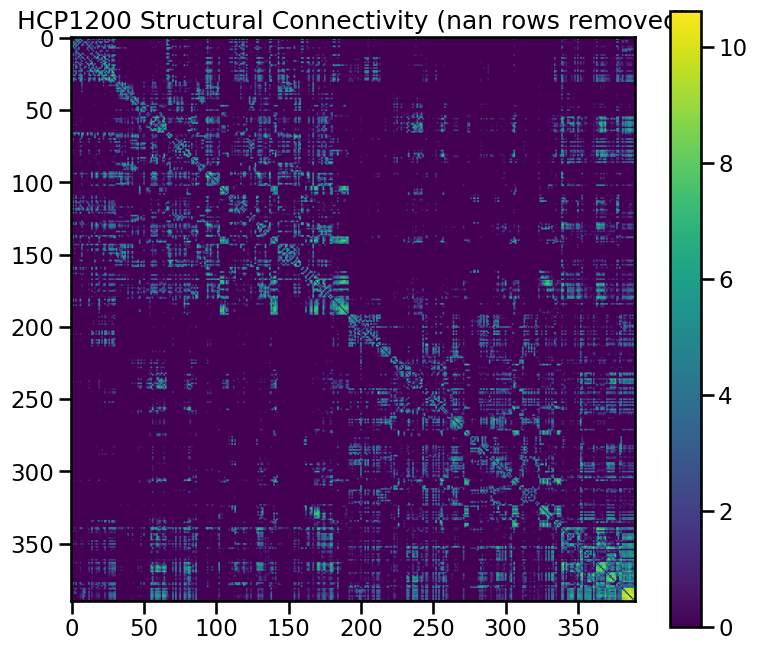

In [24]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

# Store labels and network labels from atlas info
region_labels = UKBB_S456_atlas_info['label'].tolist()
network_labels = UKBB_S456_atlas_info['network_label'].tolist()
# Store MNI coordinates from atlas info as list of [x,y,z] coordinates
mni_coords = [[x, y, z] for x, y, z in zip(UKBB_S456_atlas_info['mni_x'], 
                                          UKBB_S456_atlas_info['mni_y'],
                                          UKBB_S456_atlas_info['mni_z'])]

# Remove nan rows and columns from connectomes using nan_rows directly
HCP1200_S456_structural_count = HCP1200_S456_structural_count[~nan_rows][:, ~nan_rows]

# Display resulting connectomes
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP1200 Structural Connectivity (nan rows removed)')


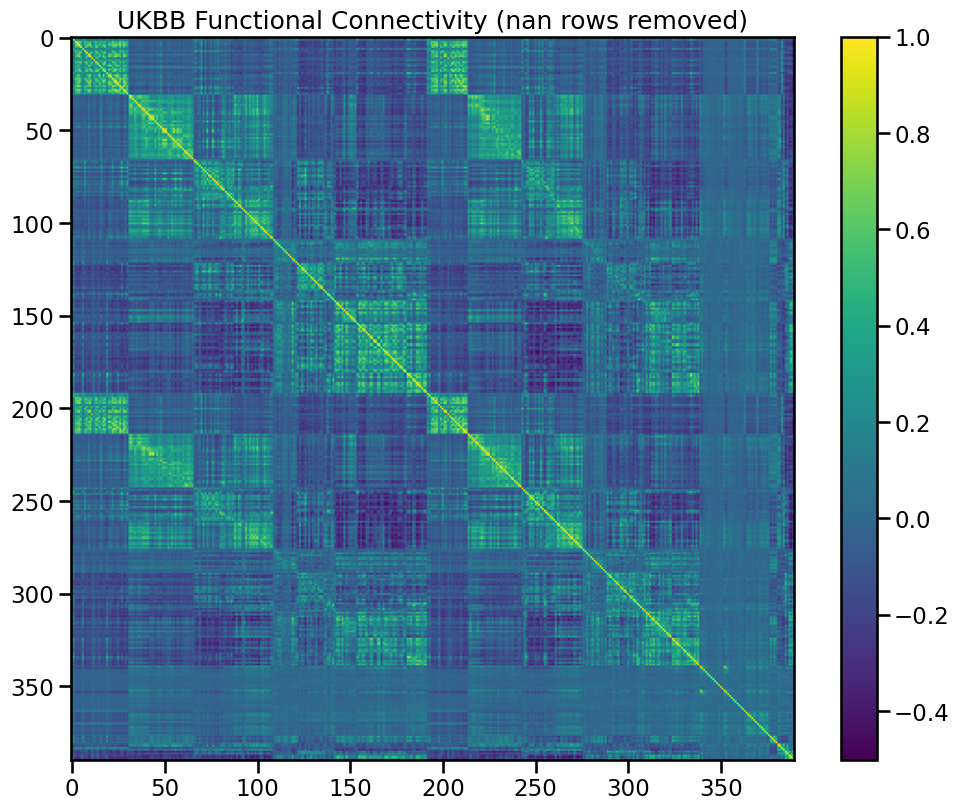

In [25]:

plt.figure(figsize=(20, 8))

UKBB_S456_functional_conn = np.array(UKBB_S456_functional_conn)[~nan_rows][:, ~nan_rows]
plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar()
plt.title('UKBB Functional Connectivity (nan rows removed)')

plt.tight_layout()
plt.show()

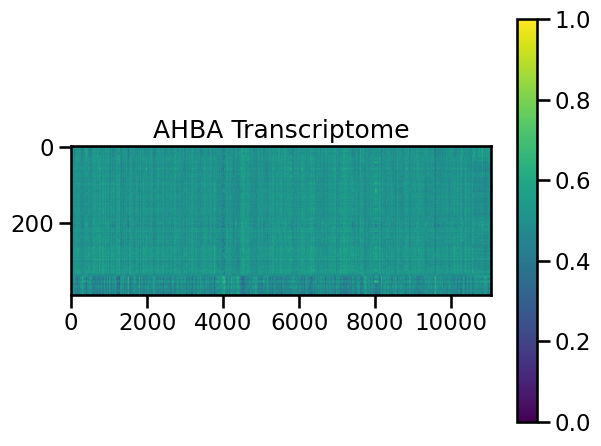

In [26]:
plt.imshow(AHBA_S456_transcriptome, cmap='viridis', aspect=10)
plt.title('AHBA Transcriptome')
plt.colorbar()
plt.tight_layout()
plt.show()


In [28]:
print("Network labels shape:", len(network_labels))
print("Region labels shape:", len(region_labels))
print("MNI coordinates shape:", len(mni_coords))

Network labels shape: 390
Region labels shape: 390
MNI coordinates shape: 390


In [29]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (390, 390)
UKBB_S456_functional_conn shape: (390, 390)


In [30]:
# Filter out subcortex and cerebellum networks
cortical_mask = ~np.array([label in ['Subcortex', 'Cerebellum'] for label in network_labels])
AHBA_cortical_transcriptome = np.array(AHBA_S456_transcriptome)[cortical_mask]
cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]
cortical_mni_coords = np.array(mni_coords)[cortical_mask]

# Filter structural and functional connectivity matrices using cortical mask
HCP1200_S456_structural_count_cortical = np.array(HCP1200_S456_structural_count)[cortical_mask][:, cortical_mask]
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[cortical_mask][:, cortical_mask]

print("Cortical transcriptome shape:", AHBA_cortical_transcriptome.shape)
print("Cortical structural connectivity shape:", HCP1200_S456_structural_count_cortical.shape)
print("Cortical functional connectivity shape:", UKBB_S456_functional_conn_cortical.shape)

Cortical transcriptome shape: (339, 11053)
Cortical structural connectivity shape: (339, 339)
Cortical functional connectivity shape: (339, 339)


In [40]:
cortical_region_labels

array(['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5',
       'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10',
       'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15',
       'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20',
       'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25',
       'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30',
       'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3',
       'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7',
       'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11',
       'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15',
       'LH_SomMot_16', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20',
       'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24',
       'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28',
       'LH_SomMot_29', 'LH_SomMot_30', 'LH_SomMot_31', 'LH_SomMot_32',
       'LH_SomMot_33'

In [41]:
# Isolate nodes from the left hemisphere only
# Create mask for left hemisphere regions
left_hemi_mask = np.array([label.startswith('LH_') for label in cortical_region_labels])

# Apply mask to all relevant arrays
AHBA_left_transcriptome = AHBA_cortical_transcriptome[left_hemi_mask]
left_network_labels = cortical_network_labels[left_hemi_mask]
left_region_labels = cortical_region_labels[left_hemi_mask]
left_mni_coords = cortical_mni_coords[left_hemi_mask]

# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_left = HCP1200_S456_structural_count_cortical[left_hemi_mask][:, left_hemi_mask]
UKBB_S456_functional_conn_left = UKBB_S456_functional_conn_cortical[left_hemi_mask][:, left_hemi_mask]

print("Left hemisphere transcriptome shape:", AHBA_left_transcriptome.shape)
print("Left hemisphere structural connectivity shape:", HCP1200_S456_structural_count_left.shape)
print("Left hemisphere functional connectivity shape:", UKBB_S456_functional_conn_left.shape)


Left hemisphere transcriptome shape: (192, 11053)
Left hemisphere structural connectivity shape: (192, 192)
Left hemisphere functional connectivity shape: (192, 192)


### Modeling tests

In [31]:
# Full cortical
X = AHBA_cortical_transcriptome
Y_sc = HCP1200_S456_structural_count_cortical
Y_fc = UKBB_S456_functional_conn_cortical

In [42]:
# Left hemisphere
X = AHBA_left_transcriptome
Y_sc = HCP1200_S456_structural_count_left
Y_fc = UKBB_S456_functional_conn_left

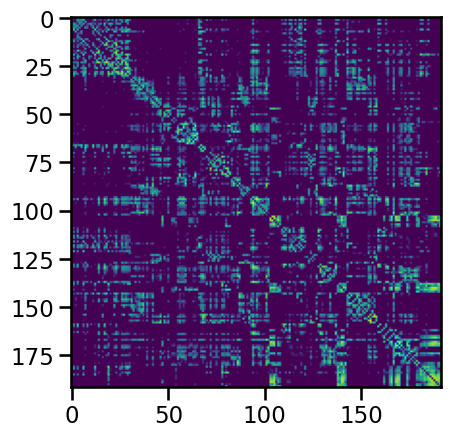

In [43]:
plt.imshow(Y_sc, cmap='viridis')

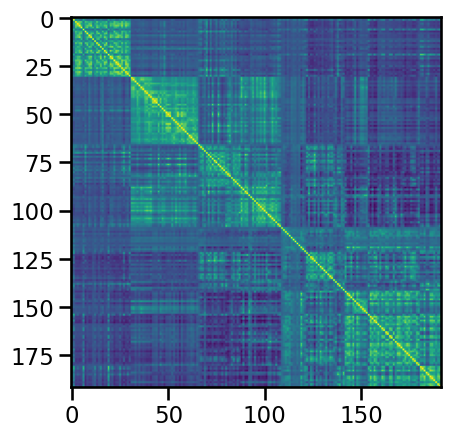

In [44]:
plt.imshow(Y_fc, cmap='viridis')

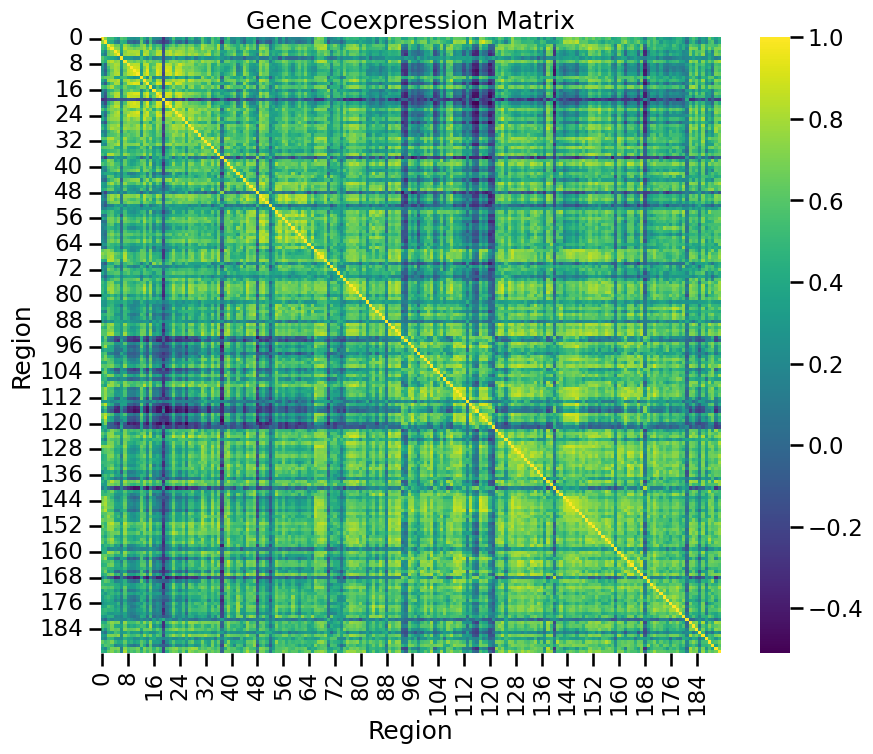

In [60]:
import seaborn as sns

# Compute the gene coexpression matrix
gene_coexpression_matrix = np.corrcoef(X)

# Plot the gene coexpression matrix
plt.figure(figsize=(10, 8))
sns.heatmap(gene_coexpression_matrix, cmap='viridis')
plt.title('Gene Coexpression Matrix')
plt.xlabel('Region')
plt.ylabel('Region')
plt.show()


X_pca shape: (192, 86)


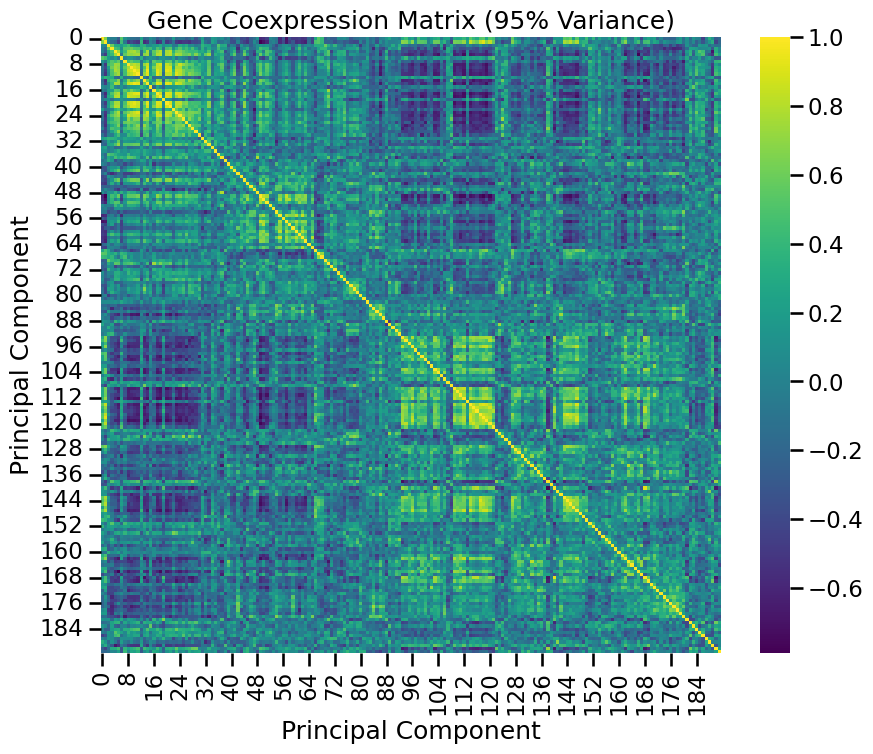

In [73]:
from sklearn.decomposition import PCA

# Perform PCA on the gene expression data
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X)
print("X_pca shape:", X_pca.shape)

# Compute the gene coexpression matrix using the PCA-transformed data
gene_coexpression_matrix_pca = np.corrcoef(X_pca, rowvar=True)

# Plot the gene coexpression matrix
plt.figure(figsize=(10, 8))
sns.heatmap(gene_coexpression_matrix_pca, cmap='viridis')
plt.title('Gene Coexpression Matrix (95% Variance)')
plt.xlabel('Principal Component')
plt.ylabel('Principal Component')
plt.show()


#### Construct the features for the GLM 

In [74]:
# Calculate euclidean distances between all pairs of regions, skipping diagonals
num_regions = len(left_mni_coords)
distances = []
sc_values = []
fc_values = []
gene_coexpression = []
gene_PCA_coexpression = []
spectral_similarity = []

# Compute spectral embeddings using method 'A' on Y_sc
_, eigenvectors = eig(Y_sc)
spectral_embeddings = eigenvectors[:, :20]  # Use the first 20 eigenvectors

for i in range(num_regions):
    for j in range(i+1, num_regions):
        # Calculate euclidean distance between regions i and j
        dist = np.sqrt(np.sum((left_mni_coords[i] - left_mni_coords[j])**2))
        distances.append(dist)
        
        # Get structural connectivity value between regions i and j
        sc_val = HCP1200_S456_structural_count_left[i, j]
        sc_values.append(sc_val)
        
        # Get functional connectivity value between regions i and j
        fc_val = UKBB_S456_functional_conn_left[i, j]
        fc_values.append(fc_val)
        
        # Calculate gene coexpression between regions i and j
        gene_coexp = np.corrcoef(X[i, :], X[j, :])[0, 1]
        gene_coexpression.append(gene_coexp)
        
        # Calculate gene PCA coexpression between regions i and j
        gene_PCA_coexp = np.corrcoef(X_pca[i, :], X_pca[j, :])[0, 1]
        gene_PCA_coexpression.append(gene_PCA_coexp)
        
        # Calculate spectral similarity between regions i and j
        spectral_sim = np.corrcoef(spectral_embeddings[i, :], spectral_embeddings[j, :])[0, 1]
        spectral_similarity.append(spectral_sim)
        
        # Check for NaNs in the dataset
        if np.isnan(dist) or np.isnan(sc_val) or np.isnan(fc_val) or np.isnan(gene_coexp) or np.isnan(gene_PCA_coexp) or np.isnan(spectral_sim):
            print(f"NaN detected at indices ({i}, {j})")

distances = np.array(distances)
sc_values = np.array(sc_values)
fc_values = np.array(fc_values)
gene_coexpression = np.array(gene_coexpression)
gene_PCA_coexpression = np.array(gene_PCA_coexpression)
spectral_similarity = np.array(spectral_similarity)

print("Distances shape:", distances.shape)
print("SC values shape:", sc_values.shape)
print("FC values shape:", fc_values.shape)
print("Gene coexpression shape:", gene_coexpression.shape)
print("Gene PCA coexpression shape:", gene_PCA_coexpression.shape)
print("Spectral similarity shape:", spectral_similarity.shape)

# Check for NaNs in the arrays
nan_distances = np.isnan(distances)
nan_sc_values = np.isnan(sc_values)
nan_fc_values = np.isnan(fc_values)
nan_gene_coexpression = np.isnan(gene_coexpression)
nan_gene_PCA_coexpression = np.isnan(gene_PCA_coexpression)
nan_spectral_similarity = np.isnan(spectral_similarity)

if np.any(nan_distances):
    print(f"NaNs detected in distances at indices: {np.where(nan_distances)}")
if np.any(nan_sc_values):
    print(f"NaNs detected in SC values at indices: {np.where(nan_sc_values)}")
if np.any(nan_fc_values):
    print(f"NaNs detected in FC values at indices: {np.where(nan_fc_values)}")
if np.any(nan_gene_coexpression):
    print(f"NaNs detected in gene coexpression at indices: {np.where(nan_gene_coexpression)}")
if np.any(nan_gene_PCA_coexpression):
    print(f"NaNs detected in gene PCA coexpression at indices: {np.where(nan_gene_PCA_coexpression)}")
if np.any(nan_spectral_similarity):
    print(f"NaNs detected in spectral similarity at indices: {np.where(nan_spectral_similarity)}")

# Compute correlations between the arrays
correlation_dist_sc = np.corrcoef(distances, sc_values)[0, 1]
correlation_dist_fc = np.corrcoef(distances, fc_values)[0, 1]
correlation_sc_fc = np.corrcoef(sc_values, fc_values)[0, 1]
correlation_dist_gene = np.corrcoef(distances, gene_coexpression)[0, 1]
correlation_sc_gene = np.corrcoef(sc_values, gene_coexpression)[0, 1]
correlation_fc_gene = np.corrcoef(fc_values, gene_coexpression)[0, 1]
correlation_dist_gene_pca = np.corrcoef(distances, gene_PCA_coexpression)[0, 1]
correlation_sc_gene_pca = np.corrcoef(sc_values, gene_PCA_coexpression)[0, 1]
correlation_fc_gene_pca = np.corrcoef(fc_values, gene_PCA_coexpression)[0, 1]
correlation_dist_spectral = np.corrcoef(distances, spectral_similarity)[0, 1]
correlation_sc_spectral = np.corrcoef(sc_values, spectral_similarity)[0, 1]
correlation_fc_spectral = np.corrcoef(fc_values, spectral_similarity)[0, 1]

print(f"Correlation between distances and SC values: {correlation_dist_sc}")
print(f"Correlation between distances and FC values: {correlation_dist_fc}")
print(f"Correlation between SC values and FC values: {correlation_sc_fc}")
print(f"Correlation between distances and gene coexpression: {correlation_dist_gene}")
print(f"Correlation between SC values and gene coexpression: {correlation_sc_gene}")
print(f"Correlation between FC values and gene coexpression: {correlation_fc_gene}")
print(f"Correlation between distances and gene PCA coexpression: {correlation_dist_gene_pca}")
print(f"Correlation between SC values and gene PCA coexpression: {correlation_sc_gene_pca}")
print(f"Correlation between FC values and gene PCA coexpression: {correlation_fc_gene_pca}")
print(f"Correlation between distances and spectral similarity: {correlation_dist_spectral}")
print(f"Correlation between SC values and spectral similarity: {correlation_sc_spectral}")
print(f"Correlation between FC values and spectral similarity: {correlation_fc_spectral}")


Distances shape: (18336,)
SC values shape: (18336,)
FC values shape: (18336,)
Gene coexpression shape: (18336,)
Gene PCA coexpression shape: (18336,)
Spectral similarity shape: (18336,)
Correlation between distances and SC values: -0.23853711030901545
Correlation between distances and FC values: -0.34423919680070386
Correlation between SC values and FC values: 0.24673914779123635
Correlation between distances and gene coexpression: -0.2658773088622252
Correlation between SC values and gene coexpression: 0.07030201001336875
Correlation between FC values and gene coexpression: 0.147313590655155
Correlation between distances and gene PCA coexpression: -0.4446085304334954
Correlation between SC values and gene PCA coexpression: 0.11881594965330432
Correlation between FC values and gene PCA coexpression: 0.2603886827668682
Correlation between distances and spectral similarity: -0.2702916384015264
Correlation between SC values and spectral similarity: 0.6386100193560201
Correlation between F

In [70]:
import statsmodels.api as sm
# Prepare the data for the GLM
X_glm = np.column_stack((distances, sc_values, gene_coexpression, gene_PCA_coexpression, spectral_similarity))
X_glm = sm.add_constant(X_glm)  # Add a constant to the model
Y_glm = fc_values

print(X_glm.shape)

# Fit the GLM
model = sm.OLS(Y_glm, X_glm)
results = model.fit()

# Print the summary of the GLM
print(results.summary())

# Extract R^2 for each individual feature
r_squared_distance = sm.OLS(Y_glm, sm.add_constant(distances)).fit().rsquared
r_squared_sc = sm.OLS(Y_glm, sm.add_constant(sc_values)).fit().rsquared
r_squared_gene = sm.OLS(Y_glm, sm.add_constant(gene_coexpression)).fit().rsquared
r_squared_gene_pca = sm.OLS(Y_glm, sm.add_constant(gene_PCA_coexpression)).fit().rsquared
r_squared_spectral = sm.OLS(Y_glm, sm.add_constant(spectral_similarity)).fit().rsquared

print(f"R^2 for distance: {r_squared_distance}")
print(f"R^2 for SC: {r_squared_sc}")
print(f"R^2 for gene coexpression: {r_squared_gene}")
print(f"R^2 for gene PCA coexpression: {r_squared_gene_pca}")
print(f"R^2 for spectral similarity: {r_squared_spectral}")


(18336, 6)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     789.4
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:30:54   Log-Likelihood:                 4558.4
No. Observations:               18336   AIC:                            -9105.
Df Residuals:                   18330   BIC:                            -9058.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1328      0.005     25.6

In [81]:
import statsmodels.api as sm

# Create concatenated gene expression PCs for each pair of regions
gene_pca_features = [
    np.hstack([X_pca[i, :], X_pca[j, :]])
    for i, j in zip(*np.triu_indices(num_regions, k=1))
]

# Create concatenated spectral embeddings for each pair of regions
spectral_features = [
    np.hstack([spectral_embeddings[i, :], spectral_embeddings[j, :]])
    for i, j in zip(*np.triu_indices(num_regions, k=1))
]

# Stack all features together
X_glm = np.column_stack((
    distances, 
    sc_values, 
    gene_coexpression, gene_PCA_coexpression, spectral_similarity,
    gene_pca_features, 
    spectral_features
))
X_glm = sm.add_constant(X_glm)  # Add a constant to the model
Y_glm = fc_values

print(X_glm.shape)

# Fit the GLM
model = sm.OLS(Y_glm, X_glm)
results = model.fit()

# Print the summary of the GLM
print(results.summary())
# Extract R^2 for each group of features
r_squared_distance = sm.OLS(Y_glm, sm.add_constant(distances)).fit().rsquared
r_squared_sc = sm.OLS(Y_glm, sm.add_constant(sc_values)).fit().rsquared
r_squared_gene = sm.OLS(Y_glm, sm.add_constant(gene_coexpression)).fit().rsquared
r_squared_gene_pca = sm.OLS(Y_glm, sm.add_constant(gene_pca_features)).fit().rsquared
r_squared_spectral = sm.OLS(Y_glm, sm.add_constant(spectral_features)).fit().rsquared

print(f"R^2 for distance: {r_squared_distance}")
print(f"R^2 for SC: {r_squared_sc}")
print(f"R^2 for gene coexpression: {r_squared_gene}")
print(f"R^2 for gene PCA: {r_squared_gene_pca}")
print(f"R^2 for spectral: {r_squared_spectral}")

(18336, 218)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     79.53
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:53:19   Log-Likelihood:                 8905.1
No. Observations:               18336   AIC:                        -1.737e+04
Df Residuals:                   18118   BIC:                        -1.567e+04
Df Model:                         217                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2523      0.011     23

In [32]:
cv_obj = RandomCVSplit(X, Y_fc, num_splits=3, shuffled=True, use_random_state=True, random_seed=42)
cv_obj.display_splits()

TRAIN: [  0   1   2   4   6   8  10  11  12  13  14  15  20  21  22  23  26  27
  28  29  30  32  34  35  36  37  38  40  41  43  44  47  48  49  50  51
  52  53  54  56  58  61  62  64  65  67  68  69  70  71  74  80  81  83
  85  86  87  88  89  91  92  93  95  96  97  98  99 100 102 103 105 106
 107 112 115 117 120 121 122 123 125 127 128 129 130 131 133 134 135 136
 138 141 142 146 149 150 151 153 154 156 157 159 160 161 162 164 166 167
 168 169 170 171 174 175 178 179 180 183 184 185 186 187 188 189 190 191
 192 193 195 196 200 201 202 204 205 206 207 212 213 214 215 216 217 218
 219 220 223 224 225 226 227 229 230 232 233 235 236 237 238 239 240 241
 243 244 245 248 249 251 252 253 255 256 257 258 259 260 262 263 264 265
 267 269 270 271 273 274 276 277 279 281 282 283 285 287 288 289 290 291
 292 293 294 295 297 299 301 303 304 307 308 309 310 311 312 313 318 320
 323 324 326 327 330 332 333 335 337 338] TEST: [  3   5   7   9  16  17  18  19  24  25  31  33  39  42  45  46  55 

In [33]:
fold_splits = process_cv_splits(X, Y_fc, cv_obj)

In [34]:
for fold_idx, (X_train, X_test, Y_train, Y_test) in enumerate(fold_splits):
    print('\n', f'Test fold num: {fold_idx+1}')
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    X_train_fold, X_test_fold, Y_train_fold, Y_test_fold = X_train, X_test, Y_train, Y_test
            


 Test fold num: 1
(50850, 22106) (50850,) (12656, 22106) (12656,)

 Test fold num: 2
(50850, 22106) (50850,) (12656, 22106) (12656,)

 Test fold num: 3
(50850, 22106) (50850,) (12656, 22106) (12656,)


In [35]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 41.7%
RAM Usage: 25.1%
Available RAM: 282.3G
Total RAM: 377.1G
52.4G


In [36]:
# GRAB A SINGLE FOLD
print(X_train_fold.shape, Y_train_fold.shape, X_test_fold.shape, Y_test_fold.shape)

(50850, 22106) (50850,) (12656, 22106) (12656,)


In [32]:
# compute PCA to test if size is the problem...
